# Simulacion - 75.26
## TP1 - Xorshift RNGs
### Grupo 4 
### Integrantes: Joaquín Rivero, Juan Pablo Aschieri, Diego Civini, Francisco Rovira Rossel

In [1]:
import matplotlib.pyplot as plt

## Ejercicio 1

Hacemos una clase `xorshift_generator` que dada una semilla devuelve un generador de numeros aleatorios de 32 bits realizando operaciones logicas de shifteo y xor. Los valores usados para la cantidad de shifteos fueron sacados del paper.

In [2]:
class xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349


    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def normalized_rand(self):
        return self.rand() / (2**32 -1)

Obtenemos un generador con una semilla y obtenemos 100000 numeros para analizar los resultados.

In [ ]:
generator = xorshift_generator(123456789)

In [ ]:
rand_numers = []
for i in range(100000):
    rand_numers.append(generator.rand())
print(rand_numers[:5])

[766200517, 1934109686, 840266027, 3415840300, 3097790067]


Graficamos los numeros en un histograma para obtener una representacion visual aproximada de su distribucion. Como buscamos numeros aleatorios entre 0 y 2^32 -1 deberia ser un grafico similar a una dist uniforme ente 0 y 2^32 -1

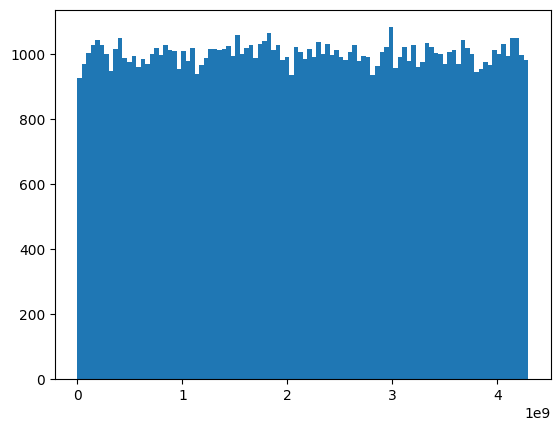

In [ ]:
plt.hist(rand_numers, bins = 100)
plt.show()

Si bien no es perfecto se puede ver como aproximadamente los distintos box tienen la misma cantidad de ocurrencias, haciendo que el grafico dado se paresca a una meseta, que es el grafico que deberia tener una uniforme.

Si queremos obtener numero aleatorios entre 0 y 1 utilizando el xorshift generator, basta con generar un numero aleatorio de la misma manera y luego normalizarlo. Para ello dividimos al numero por el mayor valor posible, 2^32 -1. De esta manera optenemos un numero aleatorio entre 0 y 1 con el metodo normalized_rand

In [ ]:
rand_numbers_normalized = []
for i in range(100000):
    rand_numbers_normalized.append(generator.normalized_rand())
print(rand_numbers_normalized[:5])

[0.4177938493475769, 0.51161216234593, 0.8245237941910801, 0.3845214700290285, 0.45587373512235324]


De la misma forma graficamos un histograma para ver si la distribucion de los numeros se asemeja a una distribucion uniforme entre 0 y 1.

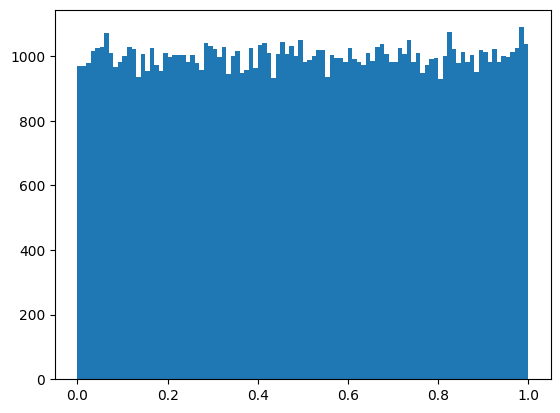

In [ ]:
plt.hist(rand_numbers_normalized, bins = 100)
plt.show()

## Ejercicio 2

enunciado

### Test chi2


Si bien el test dela chi2 necesita que la dist sea discreta, lo cual presenta un problema ya que nosotros tenemos una uniforme continua. Sin embargo para poder realizar este test, podemos discretizar la distribucion juntando valores de intervalos en bins

Tomo como h0 que la dist es uniforme. Este test NO SIRVE para decir si una dist es uniforme. Sirve para decir, si se rechaza h0 puedo decir con un nivel de significacion alfa que la dist no es uniforme. Si no se rechaza H0 entonce NO ES QUE ES UNIFORME, si no que PUEDE ser uniforme.

In [43]:
from scipy.stats import chi2

In [44]:
def get_frequency(rand_numbers, bins, max):
    frequency = [0 for i in range(bins)]

    for i in rand_numbers:
        frequency[i // int(max/bins)] += 1
    return frequency
        

In [45]:
def test_chi2_for_uniform_distribution(rand_numbers, bins, max, significance_level):
    frequency = get_frequency(rand_numbers, bins, max)

    expected_frecuency = len(rand_numbers)/bins
    aux = 0
    for i in frequency:
        aux += (i - expected_frecuency)**2
    d2 = aux/expected_frecuency

    upper_limit = chi2.ppf(1 - significance_level, df=bins-1)

    print(d2)
    print(upper_limit)
    if d2 > upper_limit:
        print("hay suf evidencia para rechazar h0")
    else:
        print("no hay suf evidencia para rechazar h0")

In [183]:
generator = xorshift_generator(565555555)



In [250]:
lista =[]
for i in range(20):
    lista.append(generator.rand())

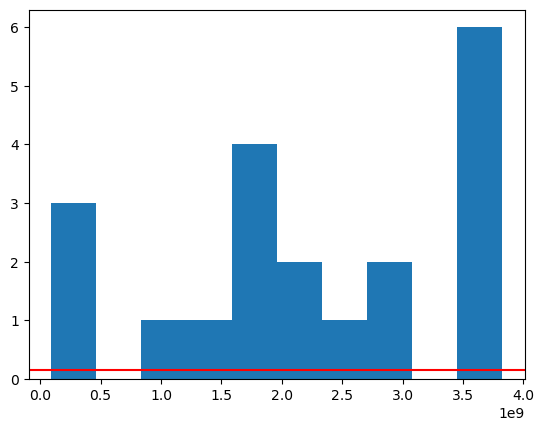

In [251]:
plt.hist(lista, bins = 10)
plt.axhline(y=len(lista)/2**7, color = 'red')
plt.show()

In [252]:
test_chi2_for_uniform_distribution(lista, 10, 2**32 - 1, 0.05)

17.0
16.918977604620448
hay suf evidencia para rechazar h0
